In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from lazypredict.Supervised import LazyClassifier
from IPython.display import display

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from UCI-ML Repo
def load_datasets():
    # Classification Datasets
    c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]
    c_mice_expression = pd.read_csv("./Classification.Mice.Expression.csv")#.iloc[:, :25]
    c_adult_income = pd.read_csv("./Classification.Adult.Income.csv")
    # Regression Datasets
    r_life_expectancy = pd.read_csv("./Regression.Life.Expectancy.csv")
    
    return c_cancer, c_mice_expression, c_adult_income, r_life_expectancy

In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [5]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

In [26]:
def ApplyPCA(X, y, cv, model, features):
    print('PCA')
    results = []
    for k in features:
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X)
        scores = cross_val_score(model, X_pca, y, cv=cv)
        results.append(scores.mean())
        print(scores.mean())
    return {'method': 'PCA', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [25]:
def ApplyFFS(X, y, cv, model, features):
    print('FFS')
    results = []
    for k in features:
        forward_feature_selector = SequentialFeatureSelector(model, n_features_to_select=k, direction='forward')
        X_forward = forward_feature_selector.fit_transform(X, y)
        scores = cross_val_score(model, X_forward, y, cv=cv)
        results.append(scores.mean())
        print(scores.mean())
    return {'method': 'Filter - FFS', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [24]:
def ApplyBFE(X, y, cv, model, features):
    print('BFE')
    results = []
    for k in features:
        backward_feature_eliminator = SequentialFeatureSelector(model, n_features_to_select=k, direction='backward')
        X_backward = backward_feature_eliminator.fit_transform(X, y)
        scores = cross_val_score(model, X_backward, y, cv=cv)
        results.append(scores.mean())
        print(scores.mean())
    return {'method': 'Filter - BFE', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [23]:
def ApplyClassificationMethods(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Initialize k-fold cross-validation
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Apply PCA
    lr_results = ApplyPCA(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    results.append(lr_results)
    rf_results = ApplyPCA(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    results.append(rf_results)
    knn_results = ApplyPCA(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    results.append(knn_results)

    # Apply FFS
    lr_results = ApplyFFS(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    results.append(lr_results)
    rf_results = ApplyFFS(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    results.append(rf_results)
    knn_results = ApplyFFS(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    results.append(knn_results)

    # Apply BFE
    lr_results = ApplyBFE(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    results.append(lr_results)
    rf_results = ApplyBFE(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    results.append(rf_results)
    knn_results = ApplyBFE(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    results.append(knn_results)

    df = pd.DataFrame(results)
    return df

In [27]:
a,b,c,d = load_datasets()
a = transform_data(a)
df = ApplyClassificationMethods(a, 'diagnosis')
df

Categorical columns: Index(['diagnosis'], dtype='object')
Numerical columns: Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
PCA
0.9455519329296692
0.9631423691973297
0.9736686849868033
PCA
0.9350411426797081
0.9543238627542306
0.9543238627542306
PCA
0.9367489520260829
0.9525539512498058
0.9578171091445427
FFS
0.9701288619779536
0.9701288619779538
0.9789318428815401
FFS
0.9578326346840551
0.9648346530041918


In [27]:
df

In [60]:
def fwpMethodsClassification(df, target_name, folds):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Initialize k-fold cross-validation where folds > 0
    for k in folds:
        if k > 0:
            k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

            # Apply chi-squared filter
            X_chi2 = SelectKBest(score_func=chi2, k=10).fit_transform(X_scaled, y)
            lr_chi2_scores = cross_val_score(lr_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            rf_chi2_scores = cross_val_score(rf_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            knn_chi2_scores = cross_val_score(knn_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            lr_chi2_mean_accuracy = lr_chi2_scores.mean()
            rf_chi2_mean_accuracy = rf_chi2_scores.mean()
            knn_chi2_mean_accuracy = knn_chi2_scores.mean()

            # Apply forward selection wrapper
            lr_forward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=10, direction='forward')
            X_forward = lr_forward_selector.fit_transform(X_scaled, y)
            lr_forward_scores = cross_val_score(lr_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            rf_forward_scores = cross_val_score(rf_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            knn_forward_scores = cross_val_score(knn_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            lr_forward_mean_accuracy = lr_forward_scores.mean()
            rf_forward_mean_accuracy = rf_forward_scores.mean()
            knn_forward_mean_accuracy = knn_forward_scores.mean()

            # Apply backward selection wrapper
            lr_backward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=10, direction='backward')
            X_backward = lr_backward_selector.fit_transform(X_scaled, y)
            lr_backward_scores = cross_val_score(lr_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            rf_backward_scores = cross_val_score(rf_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            knn_backward_scores = cross_val_score(knn_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            lr_backward_mean_accuracy = lr_backward_scores.mean()
            rf_backward_mean_accuracy = rf_backward_scores.mean()
            knn_backward_mean_accuracy = knn_backward_scores.mean()

            # Apply PCA
            pca = PCA(n_components=10)
            X_pca = pca.fit_transform(X_scaled)
            lr_pca_scores = cross_val_score(lr_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            rf_pca_scores = cross_val_score(rf_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            knn_pca_scores = cross_val_score(knn_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            lr_pca_mean_accuracy = lr_pca_scores.mean()
            rf_pca_mean_accuracy = rf_pca_scores.mean()
            knn_pca_mean_accuracy = knn_pca_scores.mean()

            results.append({
                'k': k,
                'LR with Chi2 Accuracy': lr_chi2_mean_accuracy,
                'RF with Chi2 Accuracy': rf_chi2_mean_accuracy,
                'KNN with Chi2 Accuracy': knn_chi2_mean_accuracy,
                'LR with Forward Selection Accuracy': lr_forward_mean_accuracy,
                'RF with Forward Selection Accuracy': rf_forward_mean_accuracy,
                'KNN with Forward Selection Accuracy': knn_forward_mean_accuracy,
                'LR with Backward Selection Accuracy': lr_backward_mean_accuracy,
                'RF with Backward Selection Accuracy': rf_backward_mean_accuracy,
                'KNN with Backward Selection Accuracy': knn_backward_mean_accuracy,
                'LR with PCA Accuracy': lr_pca_mean_accuracy,
                'RF with PCA Accuracy': rf_pca_mean_accuracy,
                'KNN with PCA Accuracy': knn_pca_mean_accuracy
            })

        else:
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

            # Train and evaluate Logistic Regression, Random Forest, and KNN models
            lr_classifier.fit(X_train, y_train)
            lr_pred = lr_classifier.predict(X_test)
            lr_accuracy = accuracy_score(y_test, lr_pred)

            rf_classifier.fit(X_train, y_train)
            rf_pred = rf_classifier.predict(X_test)
            rf_accuracy = accuracy_score(y_test, rf_pred)

            knn_classifier.fit(X_train, y_train)
            knn_pred = knn_classifier.predict(X_test)
            knn_accuracy = accuracy_score(y_test, knn_pred)

            results.append({
                'k': k,
                'LR Accuracy': lr_accuracy,
                'RF Accuracy': rf_accuracy,
                'KNN Accuracy': knn_accuracy
            })

    df_results = pd.DataFrame(results)
    return df_results


In [66]:
def plot_Heatmap(df):
    #DataFrame containing the data
    correlation_matrix = df.corr()

    #Determine figsize based on the number of features
    if len(correlation_matrix) <= 20:
        figsize = (12, 10)
        annot_kws = {'fontsize': 10}
    else:
        figsize = (24, 20)
        annot_kws = {'fontsize': 5}

    # Plotting the heatmap
    plt.figure(figsize = figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws=annot_kws)
    plt.title('Correlation Heatmap')
    plt.show() 

In [29]:
# Loading all Datasets into the required variables
c_cancer, c_mice_expression, c_adult_income, r_life_expectancy = load_datasets()

# Classification Datasets

## Dataset 1 : Cancer Detection Dataset (Classification)

Column Name: id
Column DataType: float64
Column has null: False


Column Name: diagnosis
Column DataType: int32
Column unique values: [1 0]
Column has null: False


Column Name: radius_mean
Column DataType: float64
Column has null: False


Column Name: texture_mean
Column DataType: float64
Column has null: False


Column Name: perimeter_mean
Column DataType: float64
Column has null: False


Column Name: area_mean
Column DataType: float64
Column has null: False


Column Name: smoothness_mean
Column DataType: float64
Column has null: False


Column Name: compactness_mean
Column DataType: float64
Column has null: False


Column Name: concavity_mean
Column DataType: float64
Column has null: False


Column Name: concave points_mean
Column DataType: float64
Column has null: False


Column Name: symmetry_mean
Column DataType: float64
Column has null: False


Column Name: fractal_dimension_mean
Column DataType: float64
Column has null: False


Column Name: radius_se
Column DataType: float64
Co

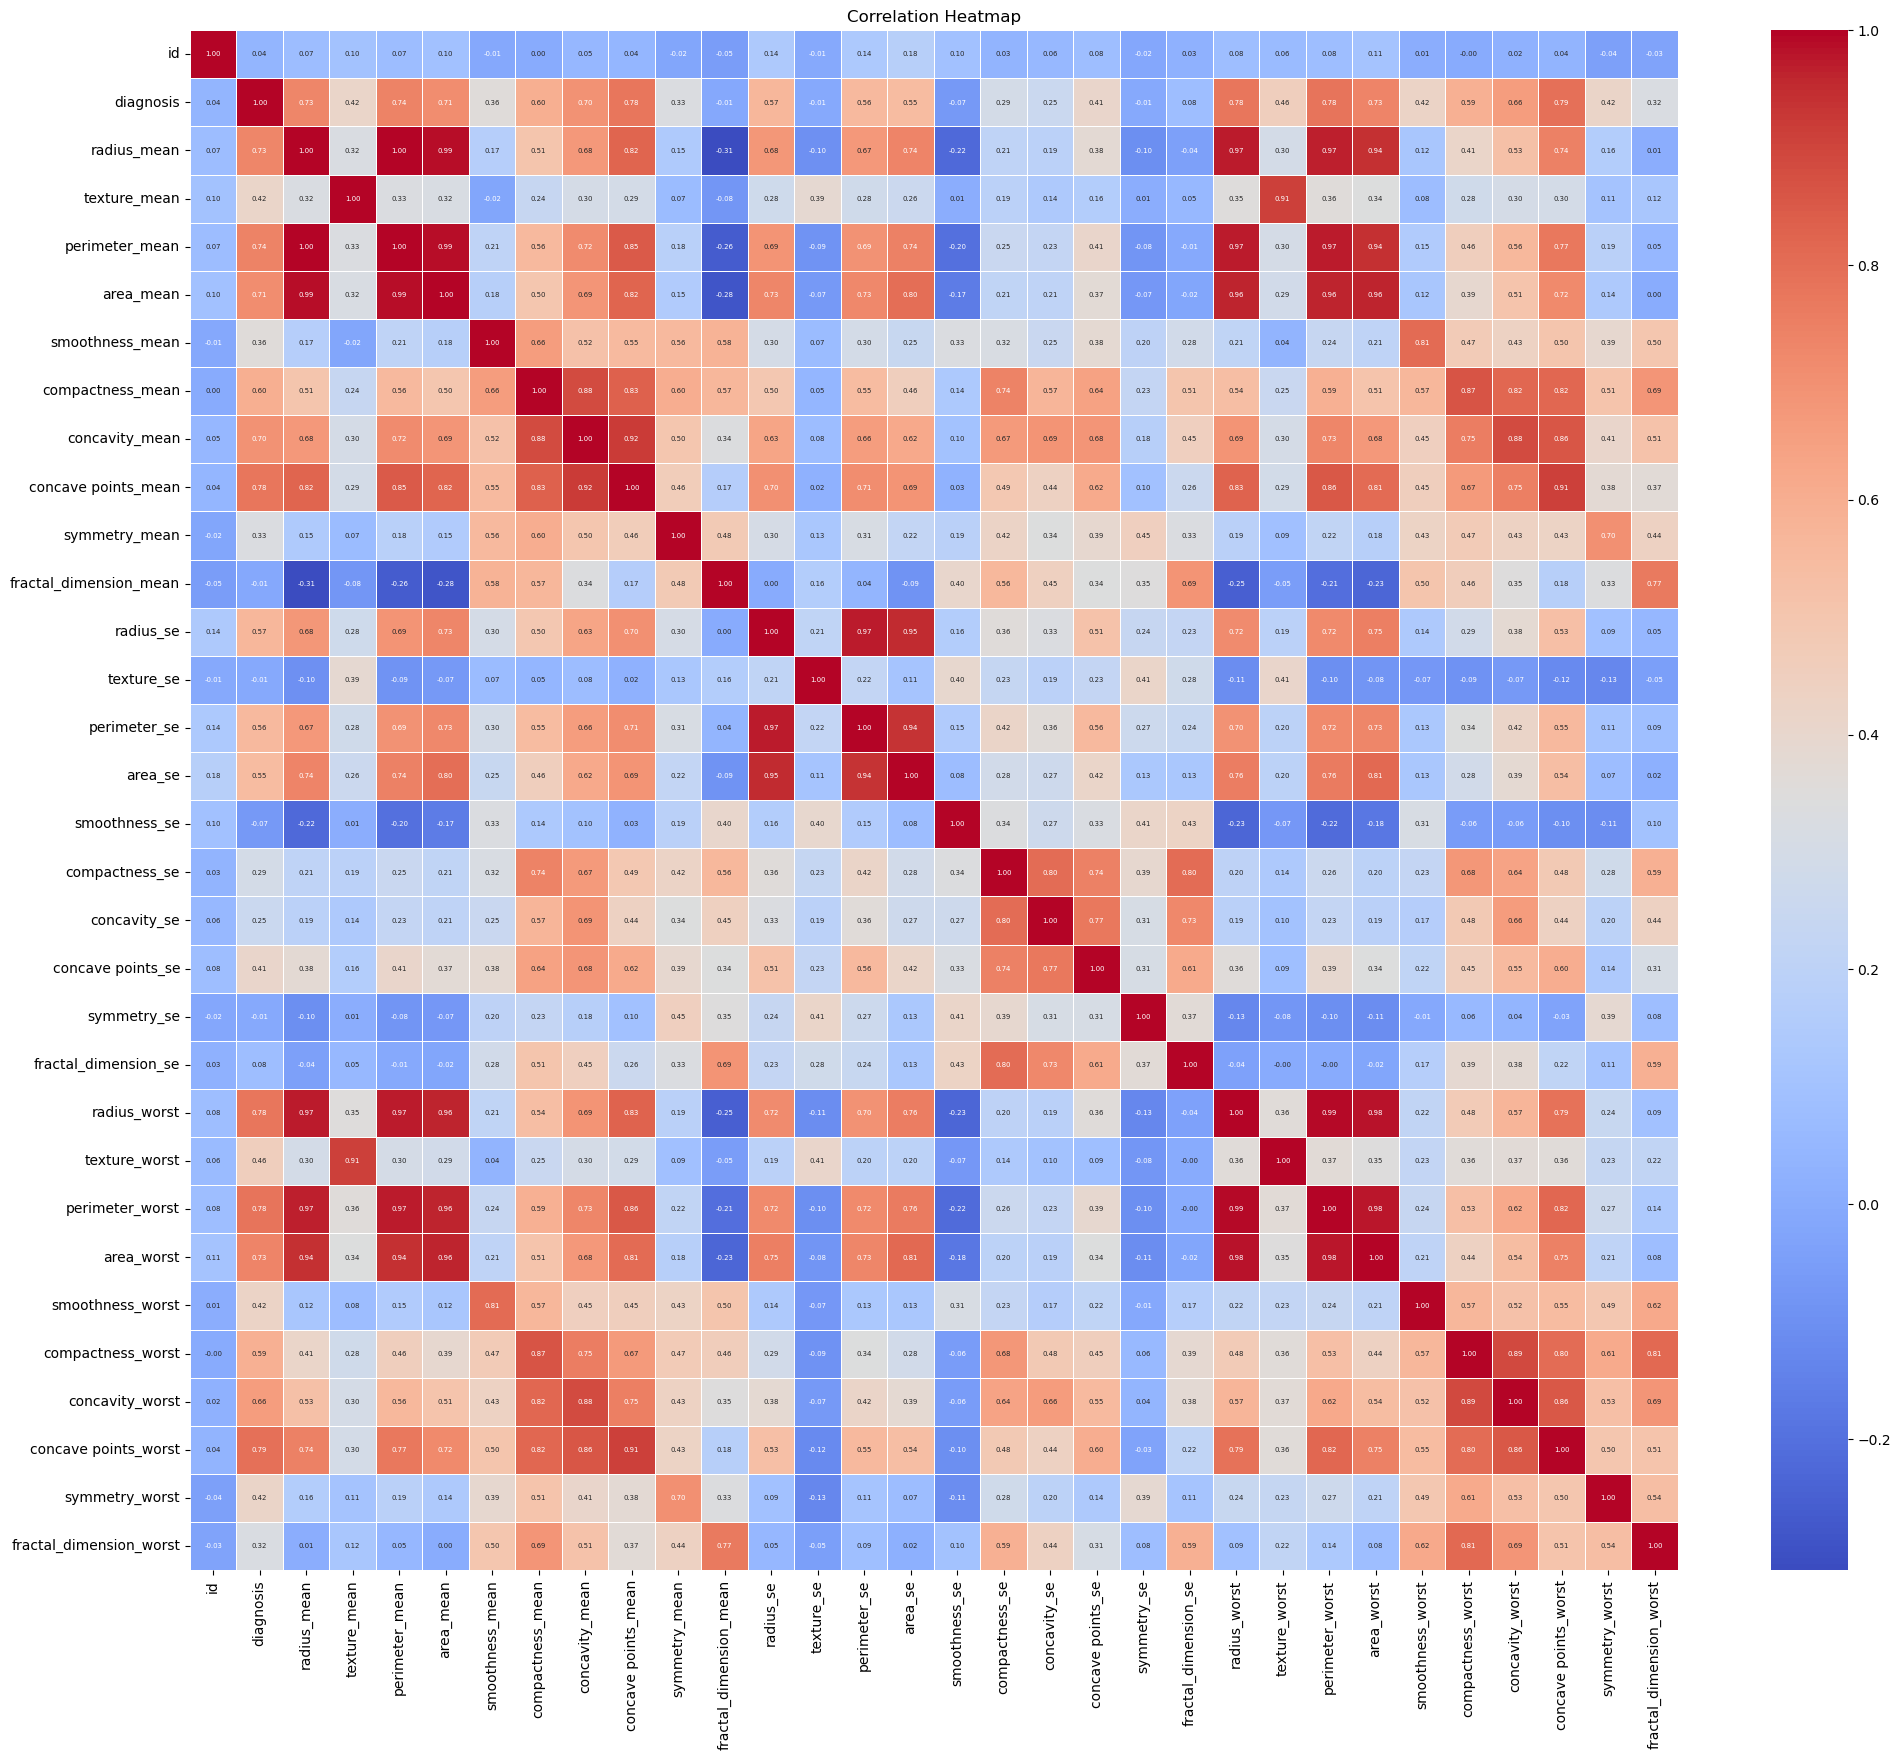

,k,LR Accuracy,RF Accuracy,KNN Accuracy,LR with Chi2 Accuracy,RF with Chi2 Accuracy,KNN with Chi2 Accuracy,LR with Forward Selection Accuracy,RF with Forward Selection Accuracy,KNN with Forward Selection Accuracy,LR with Backward Selection Accuracy,RF with Backward Selection Accuracy,KNN with Backward Selection Accuracy,LR with PCA Accuracy,RF with PCA Accuracy,KNN with PCA Accuracy
0,0,0.9825,0.9649,0.9649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,NaN,NaN,NaN,0.9350,0.9455,0.9367,0.9684,0.9596,0.9631,0.9666,0.9666,0.9684,0.9666,0.9561,0.9701
2,10,NaN,NaN,NaN,0.9386,0.9456,0.9351,0.9684,0.9579,0.9614,0.9667,0.9579,0.9719,0.9649,0.9596,0.9701


In [90]:
c_cancer
# Checking for Null Values
null_check(c_cancer)
# No Null Values present hence Encoding Categorical Data to Numerical
c_cancer = transform_data(c_cancer)
# Detailed summary of Data types in DataFrame
print(c_cancer.info())
# Plotting the heatmap
plot_Heatmap(c_cancer)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_cancer_results = fwpMethodsClassification(c_cancer, 'diagnosis', [0, 5, 10])
display(c_cancer_results)

### Interpretation:



## Dataset 2 : Mice Protein Expression Dataset (Classification)

Column Name: MouseID
Column DataType: int32
Column unique values: [  45   52   53 ... 1069 1070 1071]
Column has null: False


Column Name: DYRK1A_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: ITSN1_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: BDNF_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: NR1_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: NR2A_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pAKT_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pBRAF_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pCAMKII_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pCREB_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pELK_N
Column DataType: float64
Column has 

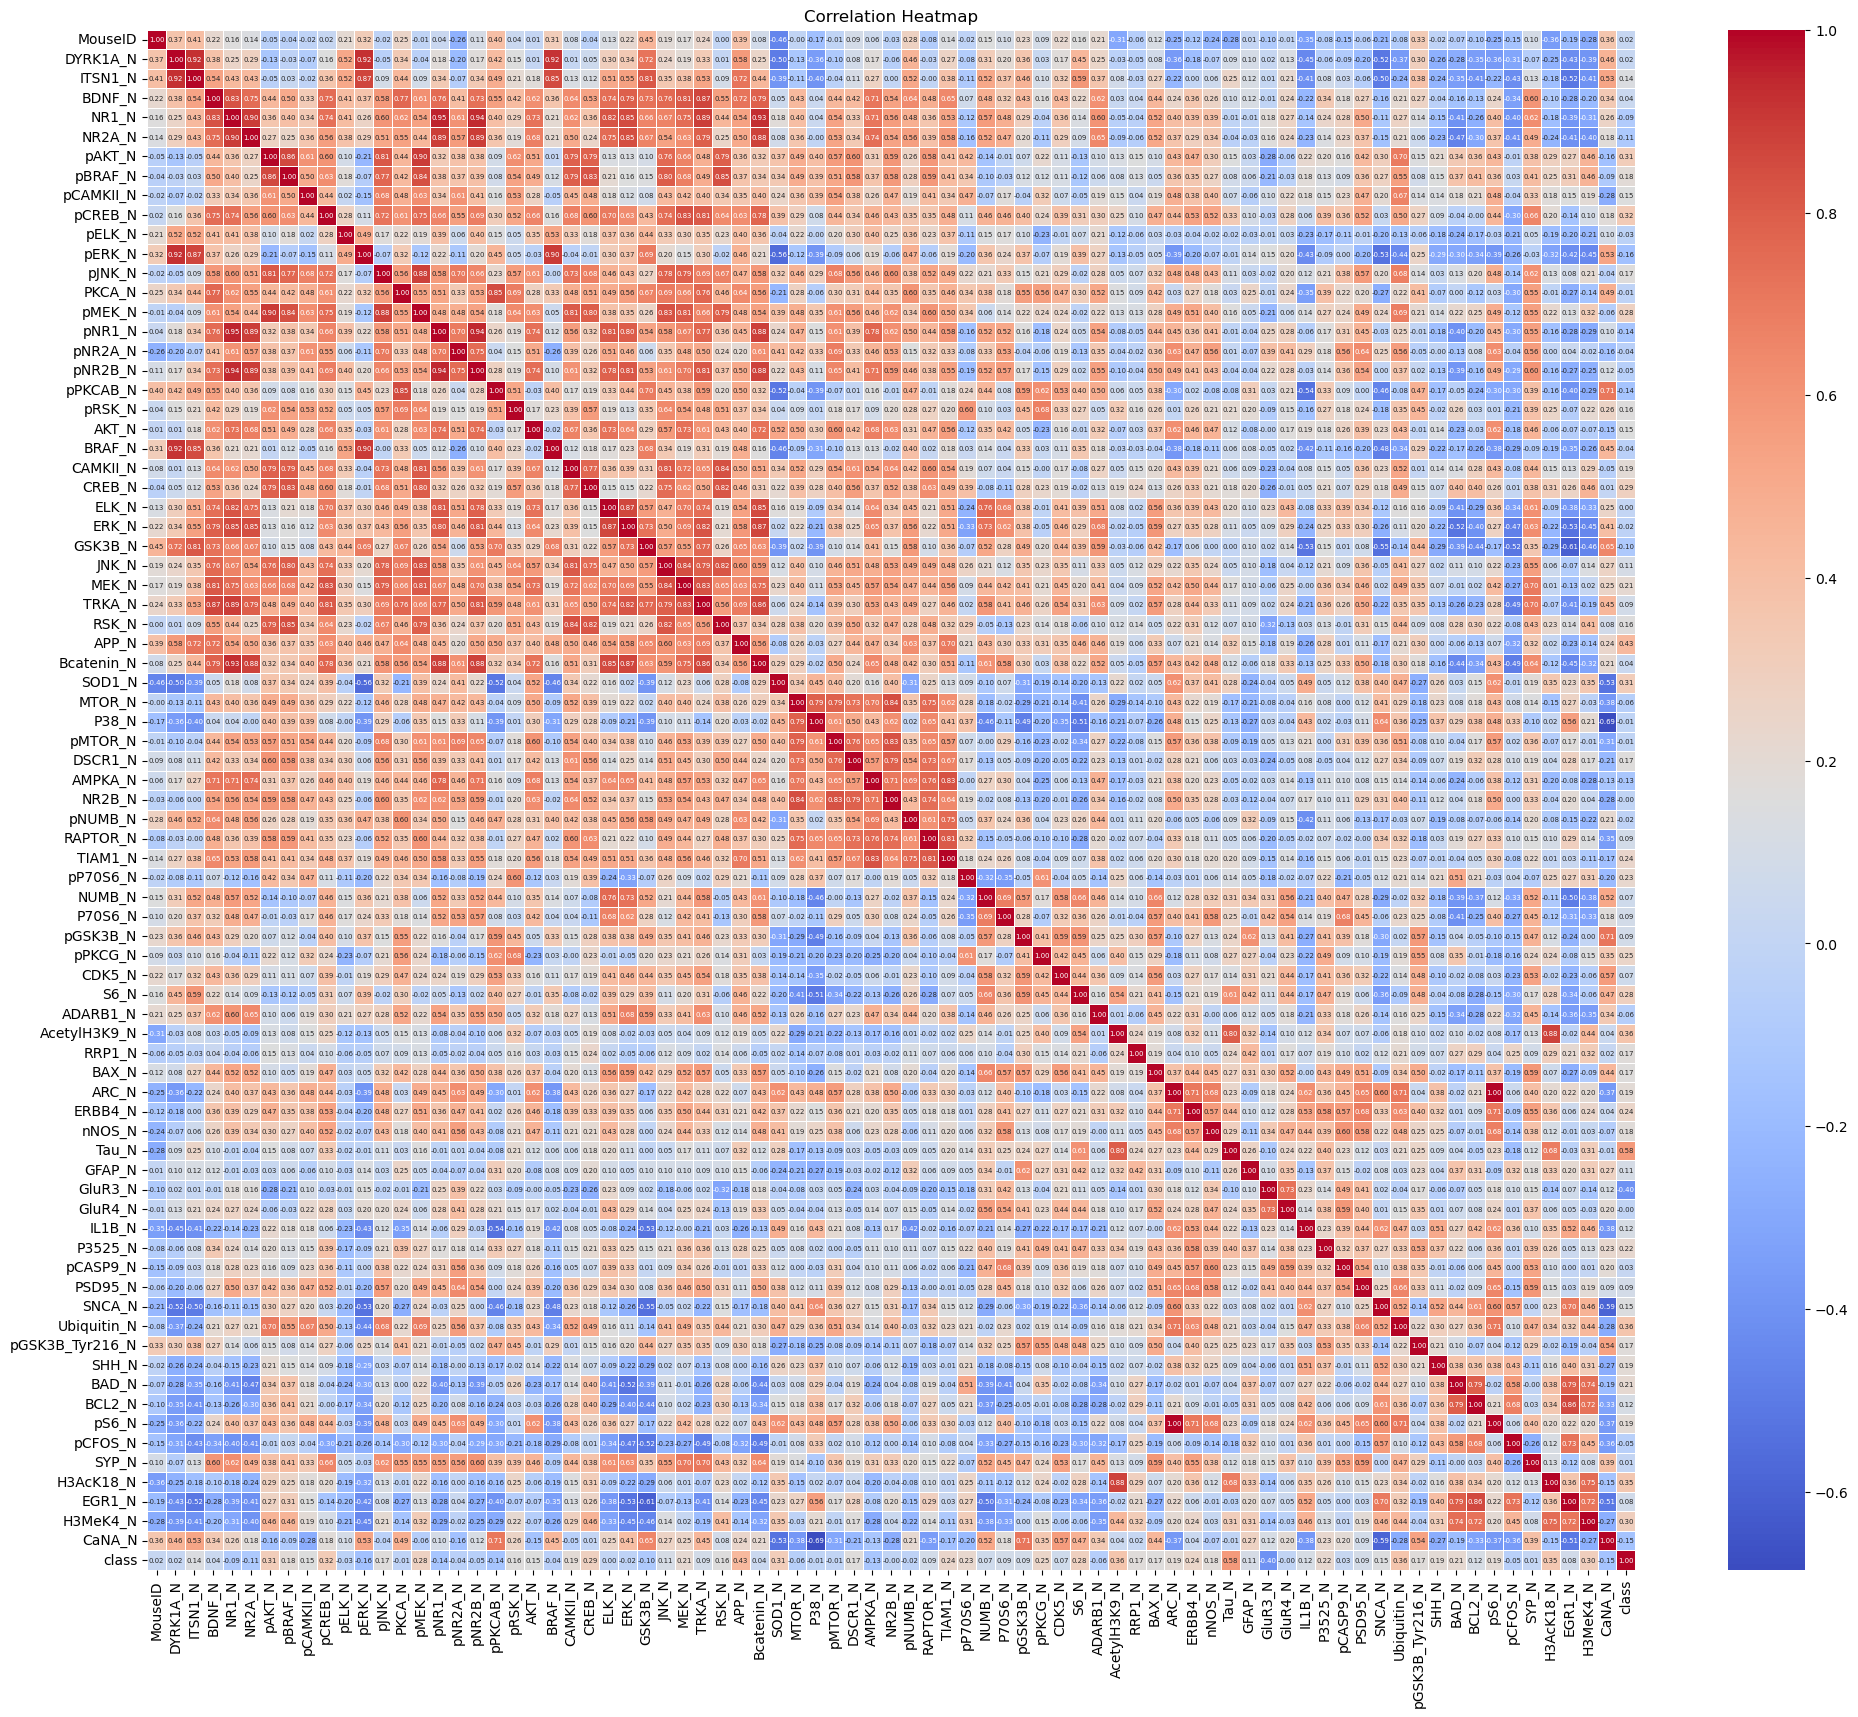

,k,LR Accuracy,RF Accuracy,KNN Accuracy,LR with Chi2 Accuracy,RF with Chi2 Accuracy,KNN with Chi2 Accuracy,LR with Forward Selection Accuracy,RF with Forward Selection Accuracy,KNN with Forward Selection Accuracy,LR with Backward Selection Accuracy,RF with Backward Selection Accuracy,KNN with Backward Selection Accuracy,LR with PCA Accuracy,RF with PCA Accuracy,KNN with PCA Accuracy
0,0,1.0000,1.0000,0.9730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,NaN,NaN,NaN,0.7554,0.9619,0.9637,0.8332,0.9619,0.9493,0.8624,0.9765,0.9874,0.9021,0.9873,0.9601
2,10,NaN,NaN,NaN,0.7590,0.9692,0.9691,0.8332,0.9728,0.9601,0.8678,0.9855,0.9873,0.9002,0.9873,0.9692


In [63]:
c_mice_expression
# Checking for Null Values
null_check(c_mice_expression)
# Null Values present hence Removing the data
clean_data(c_mice_expression,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_mice_expression = transform_data(c_mice_expression)
# Detailed summary of Data types in DataFrame
print(c_mice_expression.info())
# Plotting the heatmap
plot_Heatmap(c_mice_expression)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_mice_expression_results = fwpMethodsClassification(c_mice_expression, 'class', [0, 5, 10])
display(c_mice_expression_results)

## Dataset 3 : Adult Income Dataset (Classification)

Column Name: age
Column DataType: float64
Column has null: False


Column Name: workclass
Column DataType: int32
Column unique values: [6 5 3 0 1 8 4 7 2]
Column has null: False


Column Name: fnlwgt
Column DataType: float64
Column has null: False


Column Name: education
Column DataType: int32
Column unique values: [ 9 11  1 12  6 15  7  8  5 10 14  4  0  3 13  2]
Column has null: False


Column Name: education-num
Column DataType: float64
Column has null: False


Column Name: marital-status
Column DataType: int32
Column unique values: [4 2 0 3 5 1 6]
Column has null: False


Column Name: occupation
Column DataType: int32
Column unique values: [ 0  3  5  9  7 11  2 13  4  6 12 14 10  1  8]
Column has null: False


Column Name: relationship
Column DataType: int32
Column unique values: [1 0 5 3 4 2]
Column has null: False


Column Name: race
Column DataType: int32
Column unique values: [4 2 1 0 3]
Column has null: False


Column Name: sex
Column DataType: int32
Column unique values: [1 

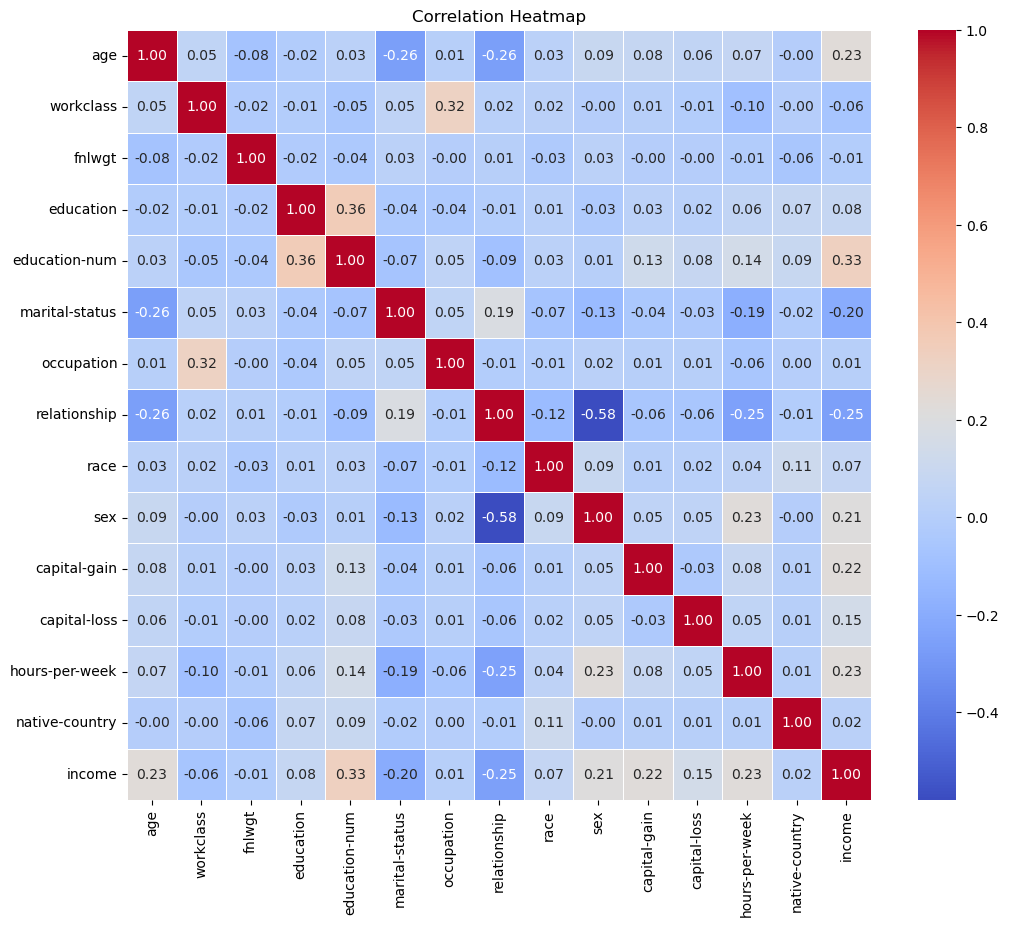

,k,LR Accuracy,RF Accuracy,KNN Accuracy,LR with Chi2 Accuracy,RF with Chi2 Accuracy,KNN with Chi2 Accuracy,LR with Forward Selection Accuracy,RF with Forward Selection Accuracy,KNN with Forward Selection Accuracy,LR with Backward Selection Accuracy,RF with Backward Selection Accuracy,KNN with Backward Selection Accuracy,LR with PCA Accuracy,RF with PCA Accuracy,KNN with PCA Accuracy
0,0,0.8238,0.8543,0.8208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,NaN,NaN,NaN,0.8242,0.8461,0.8268,0.8065,0.8344,0.8251,0.8278,0.8580,0.8268,0.8081,0.8240,0.8196
2,10,NaN,NaN,NaN,0.8239,0.8454,0.8258,0.8066,0.8341,0.8254,0.8281,0.8576,0.8268,0.8084,0.8244,0.8206


In [65]:
c_adult_income
# Checking for Null Values
null_check(c_adult_income)
# Null Values present hence Removing the data
clean_data(c_adult_income,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_adult_income = transform_data(c_adult_income)
# Detailed summary of Data types in DataFrame
print(c_adult_income.info())
# Plotting the heatmap
plot_Heatmap(c_adult_income)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.ii
c_adult_income_results = fwpMethodsClassification(c_adult_income, 'income', [0, 5, 10])
display(c_adult_income_results)